# Random quantum circuits 
### Comparison of expressibility and entangling capability for ideal and noisy circuits

## Quantum circuit simulator
This section introduces the custom simulator: how to define **states** (pure & density), set up **gates** (fixed/parametric, random sampling), build **circuits**, run **simulations** (ideal & noisy), and take **measurements**.


In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from utils.gates import ONE_QUBIT_FIXED_GATE_SET, TWO_QUBITS_FIXED_GATE_SET, FIXED_GATE_SET, \
    ONE_QUBIT_PARAMETRISED_GATE_SET, TWO_QUBITS_PARAMETRISED_GATE_SET, PARAMETRISED_GATE_SET, \
    ONE_QUBIT_GATES, TWO_QUBITS_GATES, CircuitGate, GATES
from utils.states import State, STATES, DensityState
from utils.circuit import Circuit

from utils.draw_circuit import get_circuit_plot
from utils.random_gates import sample_random_gates
from utils.noise_channels import DepolarizingNoise, TDCNoise, SPAMNoise
from utils.circuit_metrics import fidelity, fidelities_from_arrays, kl_expressibility_one_circuit, entangling_capability_ideal_from_states, entangling_capability_noisy_from_density
from utils.plots import plot_fidelity, interactive_density_matrix_plot, plot_bloch_spheres_for_states, plot_fidelity_histograms_vs_haar, plot_entangling_capability_layers_by_circuit, plot_expressibility_layers_by_circuit, plot_expressibility_vs_layers_for_circuit, plot_fidelities_by_noise

np.set_printoptions(precision=5, suppress=True)

# define rng
RNG = np.random.default_rng(4240)

### States
**Pure states** - statevector representation
- Arbitrary states can be defined with a statevector using the State class 
- STATES object contains some predefined states as well as two functions for creating new states - a zero n qubit state or a state composed of other states
- States are printed.

### States

**Pure (statevector) — `State`**

* Define any $n$-qubit state from a vector of length $2^n$: `State(np.array([...], dtype=complex))` 
* Pretty‐prints a compact ket expansion (non-zero amplitudes only).
* Utilities:

  * `get_probabilities_str(basis="Z"|"X"|"Y")` — per-basis outcome probs.
  * `measure_all(k)` — sample bitstrings; `measure_qubit(q)` — projective single-qubit measurement.
  * `normalize_state()` — normalize $|\psi\rangle$ if needed
  
**`STATES` object**

* Predefined 1-qubit: $|0⟩, |1⟩, |+⟩, |−⟩, |+i⟩, |−i⟩$; Bell states: $|Φ±⟩, |Ψ±⟩$.
* Builders:

  * `STATES.generate_zero_n_qubit_state(n)` → $|0⟩^{\otimes n}$
  * `STATES.generate_state([s1, s2, ...])` → tensor product of provided states.


In [40]:
print("|0⟩:",  State(np.array([1, 0], dtype=complex)))
print("|Ψ−⟩:", STATES.psi_minus, "\n")

print("[|+⟩ probs] X:\n" + STATES.plus.get_probabilities_str(True, "X"), "\n")

print("|0⟩^{⊗4}:", STATES.generate_zero_n_qubit_state(4), "\n")

state = STATES.generate_state([STATES.zero, STATES.psi_plus, STATES.phi_minus])
print("|0⟩ ⊗ |Ψ+⟩ ⊗ |Φ−⟩:", state)
print(f"measurement: {state.measure_all()}")

|0⟩: 1 |0⟩
|Ψ−⟩: 0.707 |01⟩ + -0.707 |10⟩ 

[|+⟩ probs] X:
P(|+⟩) = 1.00000
P(|-⟩) = 0.00000 

|0⟩^{⊗4}: 1 |0000⟩ 

|0⟩ ⊗ |Ψ+⟩ ⊗ |Φ−⟩: 0.5 |00100⟩ + -0.5 |00111⟩ + 0.5 |01000⟩ + -0.5 |01011⟩
measurement: ['00100']


**Mixed (density matrix) — `DensityState`**

* A mixed state is a density matrix $\,\rho\,$—Hermitian, positive semidefinite, with $\mathrm{Tr}(\rho)=1$—representing an ensemble of pure states; required for modeling noise (CPTP/Kraus maps).
* Create from a pure state: `DensityState.from_state(state)` or pass $\rho$ directly.
* Same probability/measurement helpers as `State` (works in any uniform basis).


In [41]:
density_state = DensityState.from_state(STATES.zero)
print("ρ (init from |0⟩):", density_state, "\n")

q = 0
density_state.apply_1q_channel(SPAMNoise().kraus_prep(q), q)

density_state.apply_unitary(GATES.X.target_qubit_matrix)
density_state.apply_1q_channel(DepolarizingNoise().kraus_for_1q("X", q), q)
density_state.apply_1q_channel(TDCNoise().kraus_for("X", q), q)

density_state.apply_unitary(GATES.H.target_qubit_matrix)
density_state.apply_1q_channel(DepolarizingNoise().kraus_for_1q("H", q), q)
density_state.apply_1q_channel(TDCNoise().kraus_for("H", q), q)

density_state.apply_1q_channel(SPAMNoise().kraus_meas(q), q)

print("ρ:", density_state, "\n")

# matrix + probs
print("ρ matrix:\n", density_state.rho, "\n")
print("[probs] Z:\n" + density_state.get_probabilities_str(True, "Z"))
print("        X:\n" + density_state.get_probabilities_str(True, "X"))


ρ (init from |0⟩): 1 |0⟩ 

ρ: 0.5 |0⟩⟨0| + -0.497 |0⟩⟨1| + -0.497 |1⟩⟨0| + 0.499 |1⟩⟨1| 

ρ matrix:
 [[ 0.49964+0.j -0.49697+0.j]
 [-0.49697+0.j  0.49931+0.j]] 

[probs] Z:
P(|0⟩) = 0.49964
P(|1⟩) = 0.49931
        X:
P(|+⟩) = 0.00250
P(|-⟩) = 0.99645


### Gates

**`GATES` object**
- Predefined `Gate` objects (fixed + parameterized):
  - Fixed 1q/2q: `I, X, Y, Z, H, S, T, CNOT, CZ`
  - Parameterized 1q/2q: `Rx, Ry, Rz, CRx, CRy, CRz`
- Each `Gate` stores its name, arity (1/2 qubits), and matrices (for controlled gates also $|0\rangle\langle 0|$, $|1\rangle\langle 1|$ controls).
- Angles: parameterized gates in `GATES` are placeholders (no angle). Angles are sampled $\theta \sim \mathcal{U}[0,2\pi)$ when a runnable circuit is built/reset via `resolve_parameters`.
  - To set a fixed angle explicitly, use e.g. `GATES.init_Rx(theta)`, `GATES.init_CRy(theta)`, etc.

**`CircuitGate`**
- Places a `Gate` on specific qubits within a circuit (target and optional control)

**Circuit drawing**
- `get_circuit_plot(...)` renders a Qiskit diagram (with placeholders for SPAM/DC/TDC). 



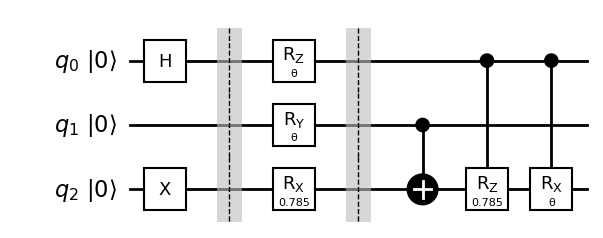

In [42]:
num_of_qubits = 3
gates=[
        [
            CircuitGate(GATES.X, target_qubit=2),
            CircuitGate(GATES.H, target_qubit=0)
        ],
        [
            CircuitGate(GATES.init_Rx(np.pi / 4), target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=0)
        ],
        [
            CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=1),
            CircuitGate(GATES.init_CRz(np.pi / 4), target_qubit=2, control_qubit=0),
            CircuitGate(GATES.CRx, target_qubit=2, control_qubit=0),
        ]
    ]
get_circuit_plot(gates, num_of_qubits)
plt.show()

**`Circuit` class**
* Simulator for parameterized quantum circuits (PQCs) with optional noise.
* Maintains both an ideal statevector (`State`) and a noisy density matrix (`DensityState`). 
* Gates may be parameterized; parameters are sampled via `resolve_parameters` on initialization and whenever the circuit is reset.
* Each gate layer is further divided into sequential timesteps
* Noise model support:
    * DepolarizingNoise (per gate/qubit as used in the paper)
    * SPAMNoise (preparation/measurement channels)
    * TDCNoise (time-dependent channel, applied after gates or SPAM steps)

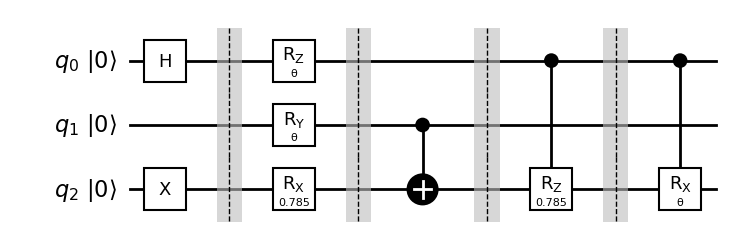

In [43]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(3),
    gates=gates,
    rng=RNG
)
get_circuit_plot(circuit.base_gates, num_of_qubits)
plt.show()

**Random gate sampling**

`sample_random_gates(num_of_qubits, layers, rng)`

**layers format:** a list of triples `(layer_type, repeats, gate_set)`, in the order you want them appended.
- `layer_type`: `"1q"` | `"2q"` | `"mixed"`
- `repeats`: how many layers of that type to add (int)
- `gate_set`: iterable of gate names (e.g., `["H","Rz"]`, `["CNOT","CZ"]`) or a preset
  (e.g., `ONE_QUBIT_GATES`, `TWO_QUBITS_GATES`, `PARAMETRISED_GATE_SET`)

Notes:
- `"1q"` layers: place one 1-qubit gate per qubit.
- `"2q"` layers: random disjoint pairs; a leftover qubit (odd `n`) gets identity.
- `"mixed"` layers: draw from 1q/2q sets; if a 2q gate can’t find a partner, it falls back to a 1q gate (or identity).
- Angles for parameterized gates are resolved later by `resolve_parameters(...)`.


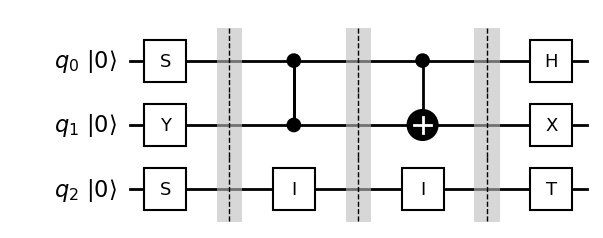

In [44]:
sampled_circuit_gates = sample_random_gates(num_of_qubits=num_of_qubits,
                                            layers=[
                                                ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
                                                ("2q", 2, TWO_QUBITS_FIXED_GATE_SET),
                                                ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
                                            ],
                                            rng=RNG)

get_circuit_plot(sampled_circuit_gates, num_of_qubits)
plt.show()

In [45]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG
)

A circuit can be simulated once or have the defined gates applied sequentially to the state in n rounds.

In [46]:
circuit.simulate_circuit()
print(circuit.state)

0.707i |000⟩ + 0.707i |001⟩


In [47]:
circuit.simulate_circuit_n_rounds(5)
print(circuit.state)

-0.5 |000⟩ + -0.5 |001⟩ + 0.5i |010⟩ + -0.5i |011⟩


In [48]:
print(circuit.state.measure_all(rng=RNG))

['010']


In [49]:
print(circuit.state.measure_all(num_of_measurements=15, rng=RNG))

['001' '000' '000' '011' '000' '010' '010' '000' '010' '001' '001' '001'
 '011' '011' '011']


# Fidelity

The notion of *fidelity* generalizes the idea of overlap between quantum states.  
It always lies in the interval $[0,1]$, with higher values meaning the states are closer.


#### 1. Pure–pure states

For two pure states $|\psi\rangle, |\phi\rangle \in \mathbb{C}^N$, the fidelity is

$$
F(|\psi\rangle, |\phi\rangle) \;=\; \big|\langle \psi \mid \phi \rangle\big|^2.
$$

- This is simply the squared inner product of the two statevectors.  
- Intuitively: it is the probability of mistaking $|\phi\rangle$ for $|\psi\rangle$ in a measurement.


#### 2. Pure–mixed state

For a pure state $|\psi\rangle$ and a mixed state $\rho$, the fidelity is

$$
F(|\psi\rangle, \rho) \;=\; \langle \psi \mid \rho \mid \psi \rangle.
$$

#### 3. Mixed–mixed states

For two mixed states $\rho$ and $\sigma$, the (Uhlmann) fidelity is defined as

$$
F(\rho, \sigma) \;=\; \Big( \operatorname{Tr}\,\sqrt{ \sqrt{\rho}\,\sigma\,\sqrt{\rho} } \,\Big)^2.
$$

- It is the standard way of measuring closeness of two general density matrices.



Suppose $|\psi_{\text{ideal}}\rangle$ is the perfect state from a noiseless simulation,  
and $\rho_{\text{noisy}}$ is the density matrix after noise channels (SPAM, depolarizing, TDC, etc.).

Then the fidelity

$$
F(|\psi_{\text{ideal}}\rangle, \rho_{\text{noisy}})
= \langle \psi_{\text{ideal}} \mid \rho_{\text{noisy}} \mid \psi_{\text{ideal}} \rangle
$$

has a simple interpretation:

- $F = 1$ → the noisy state is **identical** to the ideal one.  
- $F = 0$ → they are **orthogonal** (completely distinguishable).  
- $0 < F < 1$ → the noisy state is partially corrupted.  



In [50]:
print(f"|0⟩: {STATES.zero}")
print(f"|+⟩: {STATES.plus}")
print("F(|0⟩, |+⟩):", f"{fidelity(STATES.zero, STATES.plus):.5f}", "\n") 

print(f"ρ: ", density_state)
print("F(|0⟩, ρ):", f"{fidelity(STATES.zero, density_state):.5f}")


|0⟩: 1 |0⟩
|+⟩: 0.707 |0⟩ + 0.707 |1⟩
F(|0⟩, |+⟩): 0.50000 

ρ:  0.5 |0⟩⟨0| + -0.497 |0⟩⟨1| + -0.497 |1⟩⟨0| + 0.499 |1⟩⟨1|
F(|0⟩, ρ): 0.49964


# Noise
Added to the simulation to approximate real device behavior. Included noise channels:
(i) Depolarizing Channel
(ii) State Preparation and Measurement (SPAM) Channel
(iii) Thermal Decoherence and Dephasing Channel


## (i) Depolarizing Noise

Depolarizing noise models **gate infidelities**. After the ideal gate, the affected qubit undergoes a Pauli channel that mixes in the maximally mixed state with small probability.

- Applied **after each gate**.  
- For **1-qubit gates**: the channel acts on the operated qubit.  
- For **2-qubit gates**: the channel acts **only on the target qubit** (consistent with the asymmetric role of control vs. target in e.g. CNOT).

**Typical rates:**  
- 1-qubit gates: $p_{1}^{(1q)} \sim 10^{-3}$  
- 2-qubit gates: $p_{1}^{(2q)} \sim 5 \times 10^{-3}$  
- Often gate-dependent overrides are used (e.g. $p(\mathrm{CNOT}) \approx 0.02$).

**Mathematical representation:**  
For a density matrix $\rho$, the one-qubit depolarizing channel is
$$
\mathcal{E}_{\mathrm{depol}}(\rho)
= (1-p)\,\rho + \frac{p}{3}\Big(X\rho X + Y\rho Y + Z\rho Z\Big).
$$

- For a 1-qubit gate on qubit $q$, apply $\mathcal{E}_{\mathrm{depol}}$ to $q$.  
- For a 2-qubit gate $(c,t)$, apply $\mathcal{E}_{\mathrm{depol}}$ to the **target qubit $t$ only**.

**Kraus operators (for the affected qubit):**
$$
K_{0}=\sqrt{1-p}\,I,\qquad
K_{1}=\sqrt{\tfrac{p}{3}}\,X,\qquad
K_{2}=\sqrt{\tfrac{p}{3}}\,Y,\qquad
K_{3}=\sqrt{\tfrac{p}{3}}\,Z,
$$
so that
$$
\mathcal{E}_{\mathrm{depol}}(\rho)=\sum_{i=0}^3 K_i\,\rho\,K_i^\dagger.
$$


**`DepolarizingNoise` class**
- Holds default depolarizing probabilities for 1-qubit/2-qubit gates plus per-gate overrides.
- Includes simple validation and setters for changing probabilities.

In [51]:
depolarizing_noise=DepolarizingNoise(
    p1_1q=0.07, 
    p1_2q=0.09,
    overrides={'H': 0.08}
)

depolarizing_noise.set_default_1q(p=0.02)
depolarizing_noise.set_default_2q(p=0.05)
depolarizing_noise.set_gate(gate="X", p=0.03)
depolarizing_noise.set_gate(gate="Z", p=0.03)


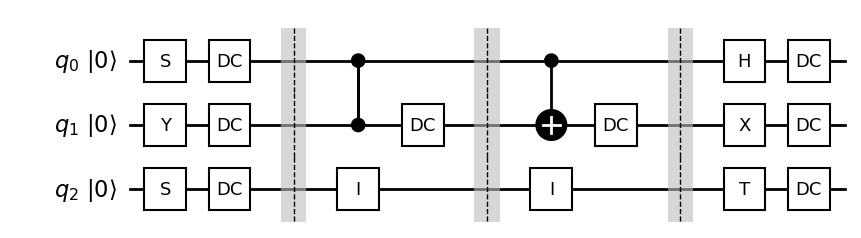

In [52]:
circuit_dc = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise()
)

get_circuit_plot(sampled_circuit_gates, num_of_qubits, depolarizing_noise=True)
plt.show()

In [53]:
circuit_dc.simulate_circuit()

print("Ideal state:", circuit_dc.state)          # noiseless result
print("Noisy state:", circuit_dc.noisy_dm)    # with noise applied

print(f"Ideal state probabilities:\n{circuit_dc.state.get_probabilities_str()}\n")
print(f"Noisy state probabilities:\n{circuit_dc.noisy_dm.get_probabilities_str()}\n")

print("Fidelity:", f"{fidelity(circuit_dc.state, circuit_dc.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.495 |000⟩⟨000| + 0.494 |000⟩⟨001| + 0.494 |001⟩⟨000| + 0.495 |001⟩⟨001| + 0.0043 |010⟩⟨010| + 0.00364 |010⟩⟨011| + 0.00364 |011⟩⟨010| + 0.0043 |011⟩⟨011| + 0.00066 |100⟩⟨100| + 0.00066 |100⟩⟨101| + 0.00066 |101⟩⟨100| + 0.00066 |101⟩⟨101| + 5.74e-06 |110⟩⟨110| + 4.85e-06 |110⟩⟨111| + 4.85e-06 |111⟩⟨110| + 5.74e-06 |111⟩⟨111|
Ideal state probabilities:
P(|000⟩) = 0.50000
P(|001⟩) = 0.50000

Noisy state probabilities:
P(|000⟩) = 0.49503
P(|001⟩) = 0.49503
P(|010⟩) = 0.00430
P(|011⟩) = 0.00430
P(|100⟩) = 0.00066
P(|101⟩) = 0.00066

Fidelity: 0.989


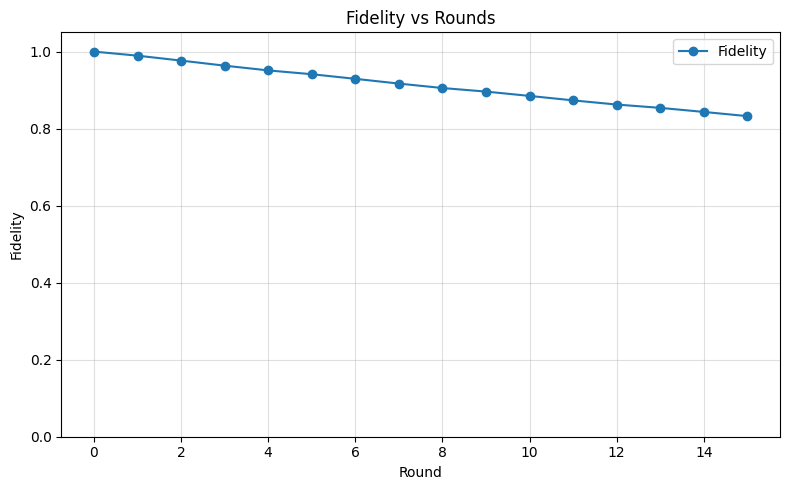

In [54]:
rounds = 15
circuit_dc.reset_circuit()
states_dc, noisy_states_dc = circuit_dc.simulate_circuit_n_rounds(rounds)

fidelities_dc = fidelities_from_arrays(states_dc, noisy_states_dc)
plot_fidelity(fidelities_dc, n_rounds=rounds)

Even at low error probabilities, depolarizing noise produces a measurable divergence from ideal state that grows with circuit depth.

In [55]:
interactive_density_matrix_plot(states_dc, noisy_states_dc)

interactive(children=(IntSlider(value=0, description='Round', max=15), Output()), _dom_classes=('widget-intera…

## (ii) SPAM Noise
 
SPAM (State Preparation And Measurement) noise models **imperfect initialization** and **readout errors**.  
- **Preparation error:** when preparing $|0\rangle$, a flip to $|1\rangle$ can occur with probability $p_2$.  
- **Measurement error:** when measuring, the outcome bit can be flipped with probability $p_2$.

**Typical rates:**  
- Preparation errors: $\sim 10^{-3}$.  
- Measurement errors: $\sim 1\%\text{–}5\%$ (platform-dependent).

**Mathematical representation (Pauli-$X$ channel):**  
Kraus operators
$$
K_{M0}=\sqrt{1-p_2}\,I,\qquad K_{M1}=\sqrt{p_2}\,X,
$$
so that
$$
\mathcal{E}_{\mathrm{SPAM}}(\rho)=(1-p_2)\rho+p_2\,X\rho X.
$$

**`SPAMNoise` class**
- Stores default and per-qubit overrides for preparation and measurement X-flip error rates.
- Includes simple validation and setters for changing probabilities.

In [56]:
spam_noise=SPAMNoise(
    p_prep_default=0.05, 
    p_meas_default=0.05,
    prep_overrides={1: 0.08, 2: 0.02},  # q: p
    meas_overrides={1: 0.2}
)

spam_noise.set_default_prep(p=0.02)
spam_noise.set_default_meas(p=0.02)
spam_noise.set_prep_qubit(q=2, p=0.04)
spam_noise.set_meas_qubit(q=2, p=0.04)

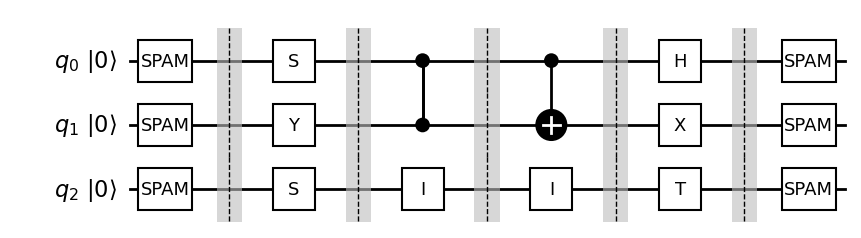

In [57]:
circuit_spam = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    spam_noise=SPAMNoise()
)

get_circuit_plot(sampled_circuit_gates, num_of_qubits, spam_noise=True)
plt.show()

In [58]:
circuit_spam.simulate_circuit()

print("Ideal state:", circuit_spam.state)          # noiseless result
print("Noisy state:", circuit_spam.noisy_dm)    # with noise applied

print(f"Ideal state probabilities:\n{circuit_spam.state.get_probabilities_str()}\n")
print(f"Noisy state probabilities:\n{circuit_spam.noisy_dm.get_probabilities_str()}\n")

print("Fidelity:", f"{fidelity(circuit_spam.state, circuit_spam.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.479 |000⟩⟨000| + 0.479 |000⟩⟨001| + 0.479 |001⟩⟨000| + 0.479 |001⟩⟨001| + 0.0107 |010⟩⟨010| + 0.00977 |010⟩⟨011| + 0.00977 |011⟩⟨010| + 0.0107 |011⟩⟨011| + 0.0103 |100⟩⟨100| + 0.0102 |100⟩⟨101| + 0.0102 |101⟩⟨100| + 0.0103 |101⟩⟨101| + 0.00023 |110⟩⟨110| + 0.000209 |110⟩⟨111| + 0.000209 |111⟩⟨110| + 0.00023 |111⟩⟨111|
Ideal state probabilities:
P(|000⟩) = 0.50000
P(|001⟩) = 0.50000

Noisy state probabilities:
P(|000⟩) = 0.47879
P(|001⟩) = 0.47879
P(|010⟩) = 0.01073
P(|011⟩) = 0.01073
P(|100⟩) = 0.01025
P(|101⟩) = 0.01025
P(|110⟩) = 0.00023
P(|111⟩) = 0.00023

Fidelity: 0.958


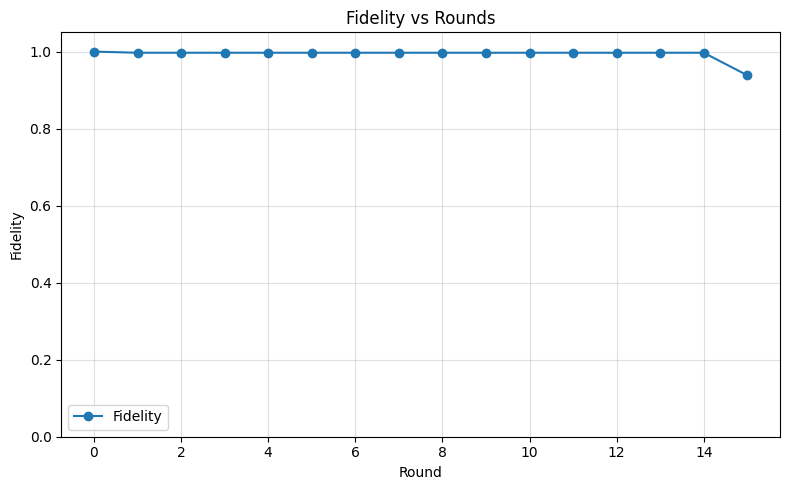

In [59]:
circuit_spam.reset_circuit()
states_spam, noisy_states_spam = circuit_spam.simulate_circuit_n_rounds(rounds)

fidelities_spam = fidelities_from_arrays(states_spam, noisy_states_spam)

plot_fidelity(fidelities_spam, n_rounds=rounds)

Because SPAM errors occur only at the initial state preparation and final measurement, they aren't tied to circuit length.

In [60]:
interactive_density_matrix_plot(states_spam, noisy_states_spam)

interactive(children=(IntSlider(value=0, description='Round', max=15), Output()), _dom_classes=('widget-intera…

## (iii) TDC Noise (Thermal Decoherence: Relaxation + Excitation + Dephasing)

Noise per gate of duration $T_g$, acting independently on each qubit:

- **Relaxation ($T_1$):** population decay $|1\rangle \to |0\rangle$  
- **Excitation (thermal):** population rise $|0\rangle \to |1\rangle$  
- **Dephasing ($T_2$):** loss of phase coherence  

At each call, the equilibrium excited-state population is  
$$
w_e \;=\; \frac{1}{1 + e^{h f / (k_B T)}} ,
$$  
set by qubit frequency $f$ and temperature $T$.

**Scales & constraint:**  
- $T_1, T_2 \sim 10$–$100 \,\mu\text{s}$  
- $T_g \sim 10$–$100 \,\text{ns}$  
- Physical constraint: $T_2 \leq 2T_1$


### Case 1: $T_2 \leq T_1$

Per-gate probabilities:

$$
p_{T1} = e^{-T_g/T_1}, \qquad
p_{T2} = e^{-T_g/T_2},
$$

$$
p_{\text{reset}} = 1 - p_{T1}, \qquad
p_{\text{reset0}} = (1 - w_e)\, p_{\text{reset}}, \qquad
p_{\text{reset1}} = w_e\, p_{\text{reset}},
$$

$$
p_Z = (1 - p_{\text{reset}})\,\frac{1 - (p_{T2}/p_{T1})}{2}, \qquad
p_I = 1 - p_Z - p_{\text{reset0}} - p_{\text{reset1}} .
$$

Channel:

$$
\rho \;\mapsto\; \sum_{k \in \{I,Z,\text{reset0},\text{reset1}\}} K_k \, \rho \, K_k^\dagger .
$$

Kraus operators:

$$
K_I = \sqrt{p_I}\, I, \quad
K_Z = \sqrt{p_Z}\, Z, \quad
K_{\text{reset0}} = \sqrt{p_{\text{reset0}}}\,|0\rangle \langle 0|, \quad
K_{\text{reset1}} = \sqrt{p_{\text{reset1}}}\,|1\rangle \langle 1| .
$$


### Case 2: $T_1 < T_2 \leq 2T_1$

Here the direct mixture above does not yield a valid CP map.  
Instead we construct the **Choi matrix** by evaluating the channel on the basis operators:

- $\mathcal{E}(|0\rangle \langle 0|) = (1-p_{\text{reset1}})|0\rangle \langle 0| + p_{\text{reset1}}|1\rangle \langle 1|$  
- $\mathcal{E}(|1\rangle \langle 1|) = p_{\text{reset0}}|0\rangle \langle 0| + (1-p_{\text{reset0}})|1\rangle \langle 1|$  
- $\mathcal{E}(|0\rangle \langle 1|) = p_{T2}\, |0\rangle \langle 1|$  
- $\mathcal{E}(|1\rangle \langle 0|) = p_{T2}\, |1\rangle \langle 0|$

Assembled into the $4 \times 4$ Choi matrix:

$$
C =
\begin{pmatrix}
1 - p_{\text{reset1}} & 0 & 0 & p_{T2} \\
0 & p_{\text{reset1}} & 0 & 0 \\
0 & 0 & p_{\text{reset0}} & 0 \\
p_{T2} & 0 & 0 & 1 - p_{\text{reset0}}
\end{pmatrix}.
$$

The channel action is then

$$
\rho \;\mapsto\; \text{Tr}_1 \!\left[ C \, (\rho^T \otimes I) \right] .
$$

**Implementation:** obtain Kraus operators by performing an SVD (or eigendecomposition if $C$ is Hermitian), then reshaping the singular/eigenvectors into $2\times 2$ matrices. This ensures a valid CPTP map.


**`TDCNoise` class**
- Tracks T1, T2, frequency, temperature (defaults + per-qubit overrides) and a gate-duration table.
- Computes per-gate thermal decoherence (relaxation/excitation/dephasing) and returns Kraus ops (explicit or via Choi/SVD).
- Provides setters/accessors for all parameters; uses physical constants (h, k) to get the thermal excited-state population.

In [61]:
tdc_noise=TDCNoise(
    T1_default=0.000002, 
    T2_default=0.000003,
    f_default=3.0e5,
    temp_default=0.1,  # mK
    
    T1_overrides={0: 0.002, 3: 0.2},  # q: p
    T2_overrides={1: 0.003},
    
    freq_overrides={0: 4.0e5, 3: 4.0e5},  # q: f
    temp_overrides={1: 0.2},  # q: t
)

tdc_noise.set_T1(q=0, T1=0.00003)
tdc_noise.set_T2(q=2, T2=0.003)
tdc_noise.set_gate_duration(gate="H", seconds=0.003)
tdc_noise.set_frequency(q=2, f_hz=4.0e7)
tdc_noise.set_temperature(q=0, T_K=0.3)

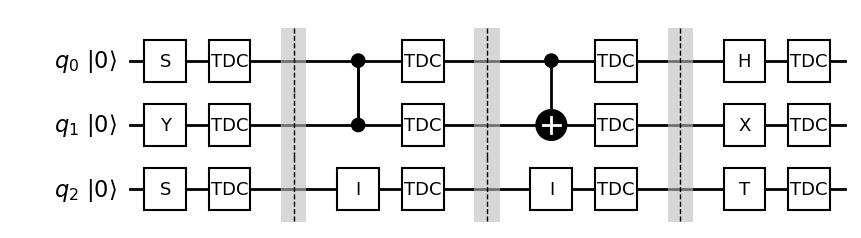

In [62]:
circuit_tdc = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    tdc_noise=TDCNoise()
)

get_circuit_plot(sampled_circuit_gates, num_of_qubits, tdc_noise=True)
plt.show()


In [63]:
circuit_tdc.simulate_circuit()

print("Ideal state:", circuit_tdc.state)          # noiseless result
print("Noisy state:", circuit_tdc.noisy_dm)    # with noise applied

print(f"Ideal state probabilities:\n{circuit_tdc.state.get_probabilities_str()}\n")
print(f"Noisy state probabilities:\n{circuit_tdc.noisy_dm.get_probabilities_str()}\n")

print("Fidelity:", f"{fidelity(circuit_tdc.state, circuit_tdc.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.5 |000⟩⟨000| + 0.5 |000⟩⟨001| + 0.5 |001⟩⟨000| + 0.5 |001⟩⟨001|
Ideal state probabilities:
P(|000⟩) = 0.50000
P(|001⟩) = 0.50000

Noisy state probabilities:
P(|000⟩) = 0.50017
P(|001⟩) = 0.49983

Fidelity: 1.000


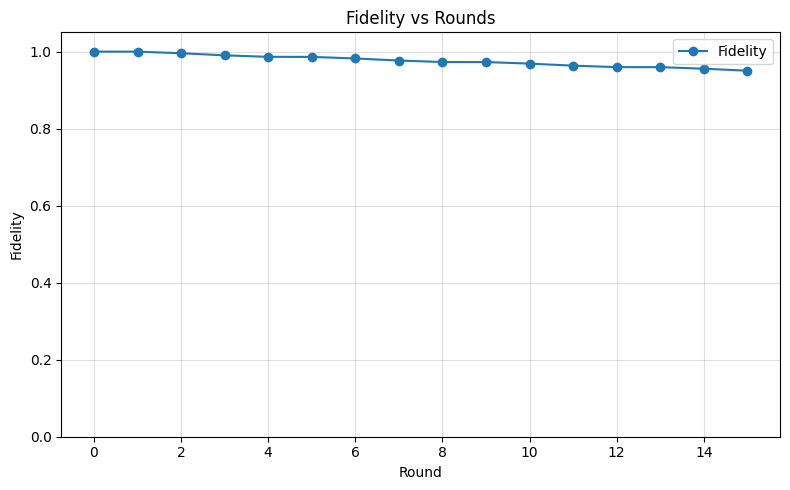

In [64]:
circuit_tdc.reset_circuit()
states_tdc, noisy_states_tdc = circuit_tdc.simulate_circuit_n_rounds(rounds)

fidelities_tdc = fidelities_from_arrays(states_tdc, noisy_states_tdc)

plot_fidelity(fidelities_tdc, n_rounds=rounds)

The noise effect on the state is observable and rises width the circuit depth, but it remains small.

In [65]:
interactive_density_matrix_plot(states_tdc, noisy_states_tdc)

interactive(children=(IntSlider(value=0, description='Round', max=15), Output()), _dom_classes=('widget-intera…

### Comparision of noise channels

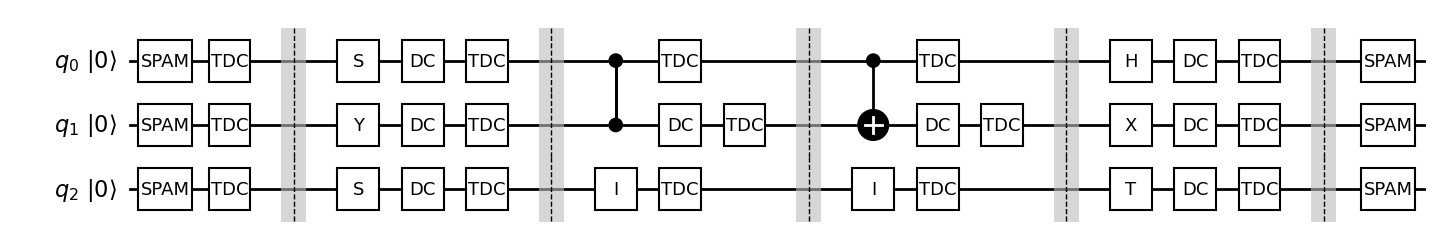

In [66]:
circuit_noisy = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise(),
    spam_noise=SPAMNoise(),
    tdc_noise=TDCNoise()
)

get_circuit_plot(sampled_circuit_gates, num_of_qubits, True, True, True)
plt.show()


In [67]:
circuit_noisy.simulate_circuit()

print("Ideal state:", circuit_noisy.state)          # noiseless result
print("Noisy state:", circuit_noisy.noisy_dm)    # with noise applied
print("Fidelity:", f"{fidelity(circuit_noisy.state, circuit_noisy.noisy_dm):.3f}")  # overlap ∈ [0,1]

Ideal state: 0.707i |000⟩ + 0.707i |001⟩
Noisy state: 0.474 |000⟩⟨000| + 0.473 |000⟩⟨001| + 0.473 |001⟩⟨000| + 0.474 |001⟩⟨001| + 0.0148 |010⟩⟨010| + 0.0132 |010⟩⟨011| + 0.0132 |011⟩⟨010| + 0.0148 |011⟩⟨011| + 0.0108 |100⟩⟨100| + 0.0108 |100⟩⟨101| + 0.0108 |101⟩⟨100| + 0.0108 |101⟩⟨101| + 0.000336 |110⟩⟨110| + 0.0003 |110⟩⟨111| + 0.0003 |111⟩⟨110| + 0.000336 |111⟩⟨111|
Fidelity: 0.947


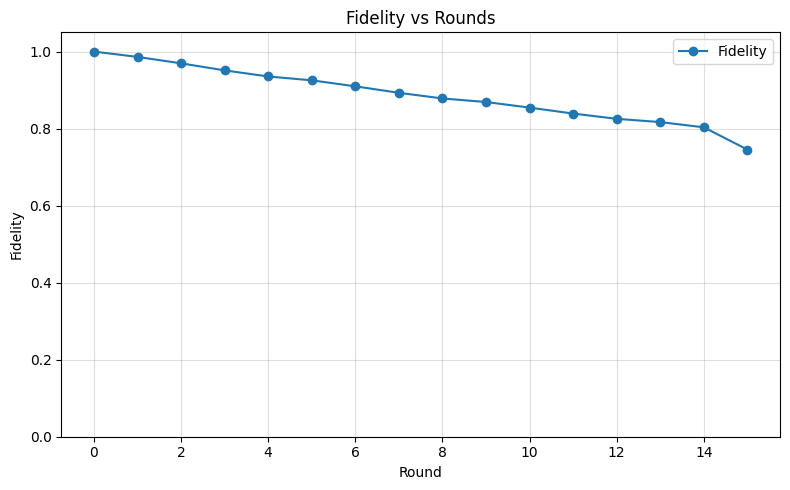

In [68]:
circuit_noisy.reset_circuit()
states_noisy, noisy_states_noisy = circuit_noisy.simulate_circuit_n_rounds(rounds)

fidelities_noisy = fidelities_from_arrays(states_noisy, noisy_states_noisy)
plot_fidelity(fidelities_noisy, n_rounds=rounds)

In [69]:
interactive_density_matrix_plot(states_noisy, noisy_states_noisy)

interactive(children=(IntSlider(value=0, description='Round', max=15), Output()), _dom_classes=('widget-intera…

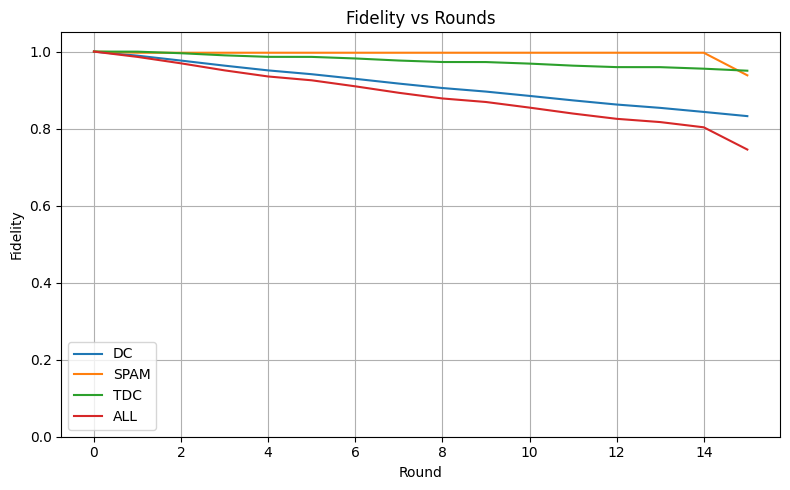

In [70]:
fidelities_by_noise = {
    "DC": fidelities_dc,
    "SPAM": fidelities_spam,
    "TDC": fidelities_tdc,
    "ALL": fidelities_noisy,
}

plot_fidelities_by_noise(fidelities_by_noise, n_rounds=rounds)

# Circuit descriptors


## Expressibility

How closely a *parameterized quantum circuit* (PQC) explores Hilbert space like a Haar-random ensemble.

**Setup (one circuit ansatz):**
Let $U(\boldsymbol\theta)$ be your PQC on $n$ qubits ($N=2^n$). Draw $S$ independent parameter vectors $\{\boldsymbol\theta_s\}_{s=1}^S$. For each:

* Ideal path (pure): $\;|\psi_s\rangle = U(\boldsymbol\theta_s)\,|0\rangle^{\otimes n}$.
* Noisy path (mixed, optional): $\;\rho_s$ = the output density matrix after applying your noise channels to the same circuit.

**Fidelity samples (pairwise):**
Build a set of non-overlapping pairs $\mathcal P=\{(1,2),(3,4),\dots\}$ (so $|\mathcal P|=S/2$), then compute

* Ideal (pure–pure) fidelity

  $$
  F_{ij}\;=\;|\langle\psi_i|\psi_j\rangle|^2 \in [0,1].
  $$
* Noisy (mixed–mixed) fidelity (Uhlmann, “squared” convention)

  $$
  \mathcal F_{ij}\;=\;\Big(\mathrm{Tr}\,\sqrt{\sqrt{\rho_i}\,\rho_j\,\sqrt{\rho_i}}\Big)^{\!2}\in[0,1].
  $$

**Empirical fidelity distributions:**
Choose fixed bin edges $\{b_k\}_{k=0}^{B}$ on $[0,1]$. Form per-bin probabilities

$$
p_k^{(\mathrm{ideal})}
=\frac{1}{|\mathcal P|}\sum_{(i,j)\in\mathcal P}\mathbf 1\!\left[F_{ij}\in[b_k,b_{k+1})\right],\qquad
p_k^{(\mathrm{noisy})}
=\frac{1}{|\mathcal P|}\sum_{(i,j)\in\mathcal P}\mathbf 1\!\left[\mathcal F_{ij}\in[b_k,b_{k+1})\right].
$$

**Haar reference (same $N=2^n$):**
For two Haar-random pure states, the fidelity pdf is

$$
p_{\mathrm{Haar}}(F;N)=(N-1)(1-F)^{N-2},\quad F\in[0,1].
$$

The corresponding bin masses are

$$
q_k\;=\;\int_{b_k}^{b_{k+1}} p_{\mathrm{Haar}}(F;N)\,dF
=\;(1-b_k)^{N-1}-(1-b_{k+1})^{N-1}.
$$

**Expressibility (KL divergence to Haar):**

$$
\;\mathrm{Expr}_{\mathrm{ideal}}
= D_{\mathrm{KL}}\!\big(P_{\mathrm{ideal}}\;\|\;Q_{\mathrm{Haar}}\big)
= \sum_{k=1}^{B} p_k^{(\mathrm{ideal})}\,\ln\!\frac{p_k^{(\mathrm{ideal})}}{q_k}\;
$$

$$
\;\mathrm{Expr}_{\mathrm{noisy}}
= D_{\mathrm{KL}}\!\big(P_{\mathrm{noisy}}\;\|\;Q_{\mathrm{Haar}}\big)
= \sum_{k=1}^{B} p_k^{(\mathrm{noisy})}\,\ln\!\frac{p_k^{(\mathrm{noisy})}}{q_k}\;
$$


* Lower KL $\Rightarrow$ **higher expressibility**.
* Expressibility for Haar itself would give $0$.
- High expressibility → circuit can approximate Haar-random states.  
- Low expressibility → circuit explores only a small subspace.


### Entangling capability

**Setup.** Let $U(\boldsymbol\theta)$ be an $n$-qubit ansatz ($N=2^n$). Draw a set of parameter samples $S=\{\boldsymbol\theta_s\}_{s=1}^S$. For each sample,

$$
|\psi_{\boldsymbol\theta}\rangle \;=\; U(\boldsymbol\theta)\,|0\rangle^{\otimes n}, 
\qquad 
\rho_{\boldsymbol\theta} \text{ (noisy output).}
$$

#### Pure-state definition (paper)

For a pure state $|\psi\rangle$, the **Meyer–Wallach global entanglement** is

$$
Q(|\psi\rangle)\;=\;\frac{2}{n}\sum_{j=1}^{n}\!\Bigl(1-\operatorname{Tr}\,\rho_j^{\,2}\Bigr),
\qquad
\rho_j \;=\; \operatorname{Tr}_{\{1,\dots,n\}\setminus\{j\}}\!\bigl(|\psi\rangle\langle\psi|\bigr).
$$

The **entangling capability** of the ansatz (ideal, pure outputs) is the sample mean

$$
\mathrm{Ent}_{\text{ideal}}
\;=\;
\frac{1}{|S|}\sum_{\boldsymbol\theta\in S} Q\!\bigl(|\psi_{\boldsymbol\theta}\rangle\bigr).
$$

**Haar baseline.** For Haar-random pure states in dimension $N=2^n$,

$$
\mathbb{E}_{\text{Haar}}[Q]\;=\;\frac{N-2}{N+1},
$$

which serves as a reference line in plots.

#### Mixed-state proxy (noisy runs)

For a mixed output state $\rho$, a practical, scale-matched proxy is the **average single-qubit linear entropy**:

$$
\tilde Q(\rho)
\;=\;
\frac{2}{n}\sum_{j=1}^{n}\!\Bigl(1-\operatorname{Tr}\,\rho_j^{\,2}\Bigr),
\qquad
\rho_j \;=\; \operatorname{Tr}_{\{1,\dots,n\}\setminus\{j\}}(\rho).
$$

Define the **noisy entangling capability** as

$$
\mathrm{Ent}_{\text{noisy}}
\;=\;
\frac{1}{|S|}\sum_{\boldsymbol\theta\in S} \tilde Q\!\bigl(\rho_{\boldsymbol\theta}\bigr).
$$



- This proxy remains in $[0,1]$ and aligns numerically with the pure-state $Q$, though it is not an entanglement monotone (it includes classical mixedness).
- High entangling capability → circuit tends to create strongly entangled states.  
- Low entangling capability → circuit output remains weakly entangled or separable.





# Random circuits
## One qubit
* Four 1-qubit circuits: one idle, three parameterized; all rotation angles are sampled uniformly from [0, 2π).
* For each circuit, 2000 random draws are simulated, saving both ideal statevectors and noisy density matrices (Depol + SPAM + TDC).
* Results are stored in `states` (ideal) and `noisy_states` (noisy).


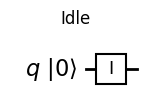

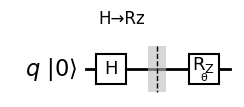

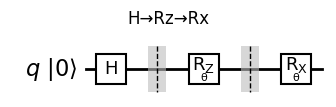

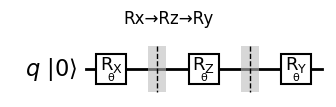

In [71]:
num_of_qubits = 1
samples = 2000
dim = 2 ** num_of_qubits  # Hilbert space dimension
num_of_circuits = 4

# Arrays to store pure vectors and noisy density matrices
states = np.zeros((num_of_circuits, samples, dim, 1), dtype=complex)       # statevectors (ideal)
noisy_states = np.zeros((num_of_circuits, samples, dim, dim), dtype=complex)  # density matrices

circuits_gates_list = [
    [[CircuitGate(GATES.I, target_qubit=0)]],
    [[CircuitGate(GATES.H, target_qubit=0)], [CircuitGate(GATES.Rz, target_qubit=0)]],
    [[CircuitGate(GATES.H, target_qubit=0)], [CircuitGate(GATES.Rz, target_qubit=0)], [CircuitGate(GATES.Rx, target_qubit=0)]],
    [[CircuitGate(GATES.Rx, target_qubit=0)], [CircuitGate(GATES.Rz, target_qubit=0)], [CircuitGate(GATES.Ry, target_qubit=0)]]
]

labels = ["Idle", "H→Rz", "H→Rz→Rx", "Rx→Rz→Ry"]
for gates, title in zip(circuits_gates_list, labels):
    fig = get_circuit_plot(gates, num_of_qubits)
    fig.axes[0].set_title(title)


    plt.tight_layout()
    plt.show() 


for circ_idx, circuit_gates_list in enumerate(circuits_gates_list):
    circuit = Circuit(
        state=STATES.generate_zero_n_qubit_state(1),
        gates=circuit_gates_list,
        rng=RNG,
        depolarizing_noise=DepolarizingNoise(),
        spam_noise=SPAMNoise(),
        tdc_noise=TDCNoise()
    )
    
    for i in range(samples):
        circuit.simulate_circuit()
        
        states[circ_idx, i, :, :] = circuit.state.qubit_vector
        noisy_states[circ_idx, i, :, :] = circuit.noisy_dm.rho
        
        circuit.reset_circuit()


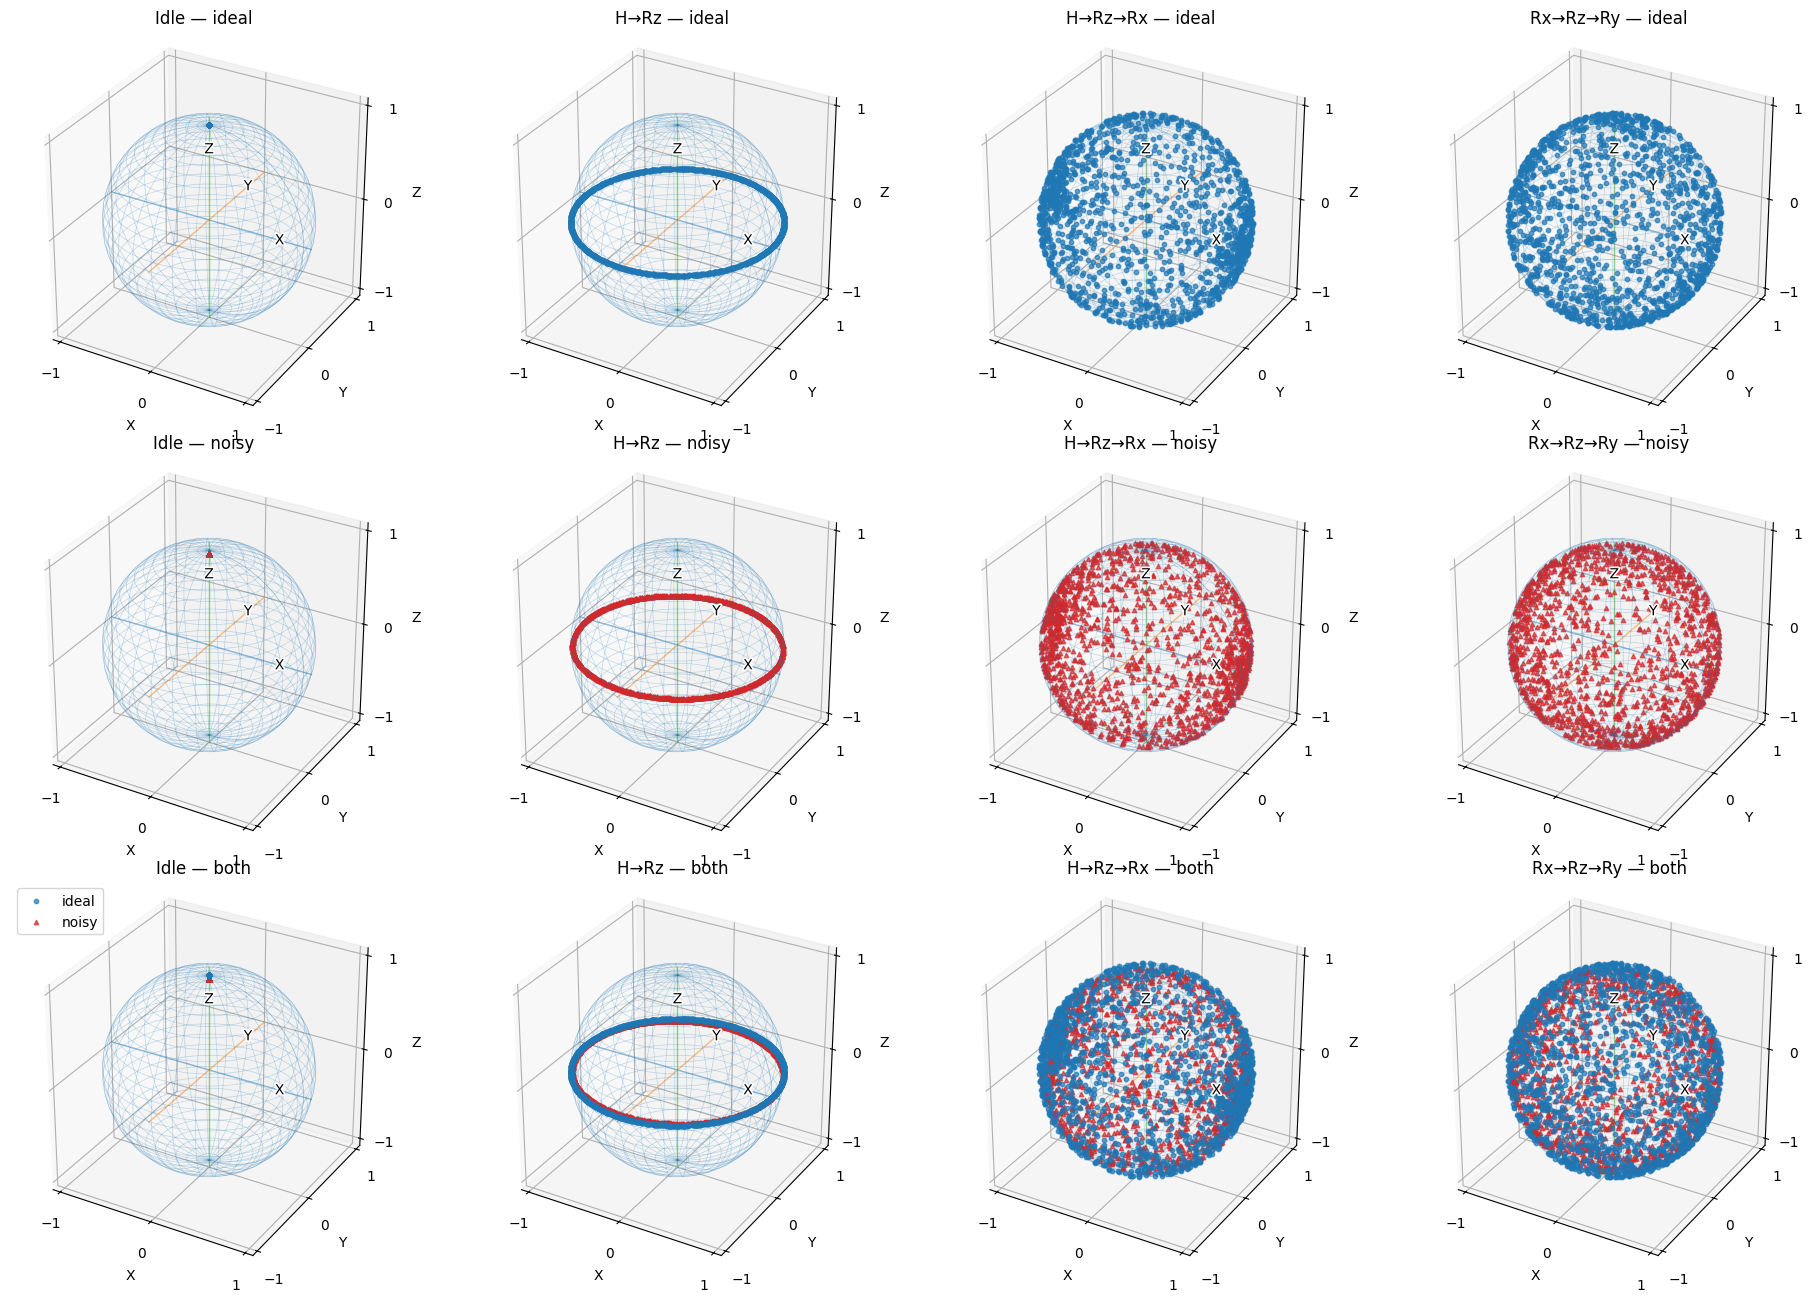

In [72]:
plot_bloch_spheres_for_states(states, noisy_states, circuit_labels=labels,
                          max_points_per_circuit=1500, stride=None, point_size=10, alpha=0.7)

Ideal (noise-free) outputs are pure states, so their Bloch vectors have length $|\mathbf r|=1$ and lie **on** the sphere. With noise added to the circuit the outputs become **mixed**, which means $|\mathbf r|<1$; completely positive trace-preserving channels (depolarizing, dephasing $T_2$, and relaxation/excitation $T_1$) **contract** the Bloch ball—randomizing and damping coherences and pulling the state toward a thermal fixed point on the $+Z$ axis. Hence the noisy samples appear **inside** the sphere (shorter vectors).


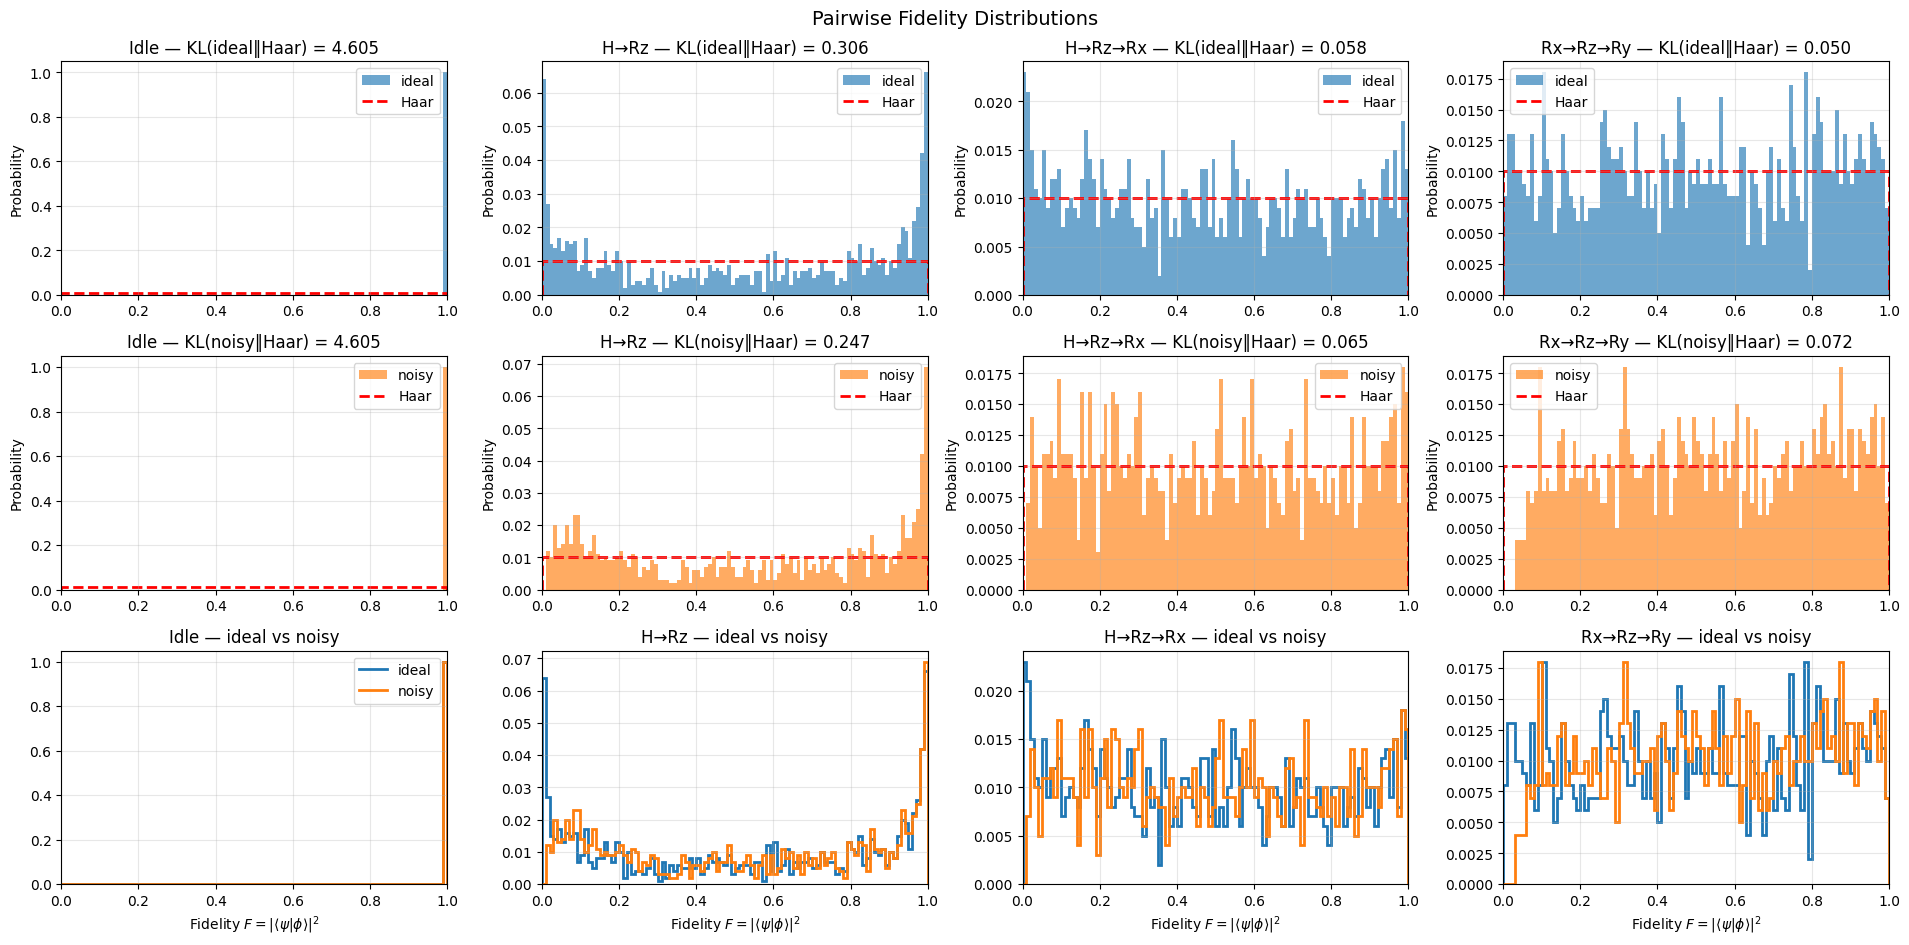

In [73]:
# states shape: (num_of_circuits, samples=2000, dim=2, 1)
KLs_ideal, KLs_noisy, bin_edges = plot_fidelity_histograms_vs_haar(
    states, noisy_states,
    circuit_labels=labels,
    num_bins=100
)

* Simple circuits (Idle, H→Rz): noise contracts states → fidelities are spread from the spike at $F\approx 1$; KL ↓ (expressibility ↑).
* More complex (H→Rz→Rx, Rx→Rz→Ry): near Haar for ideal case; noise suppresses the low-$F$ tail → KL ↑ (expressibility ↓).
    * CPTP noise (depolarizing/$T_1$/$T_2$) shrinks Bloch vectors; Uhlmann fidelities rise on average, narrowing the distribution.

# Multiple qubits random circuits

* 20 4-qubit circuits: 8 taken from the Sim et al paper and 12 randomly samples
* All rotation angles are sampled uniformly from [0, 2π).
* For each circuit, 2000 random draws are simulated, saving both ideal statevectors and noisy density matrices (Depol + SPAM + TDC).
* For each set of samples the circuit is simulated 5 times, each time with different number of layers (1-5 repeats of the circuit structure applied to the same state)
* Expressibility and entangling ability are calculated for each run
* Results are stored in `states` (ideal) and `noisy_states` (noisy).

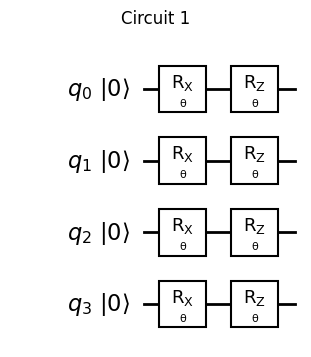

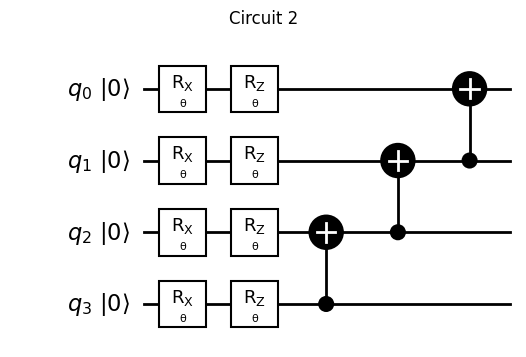

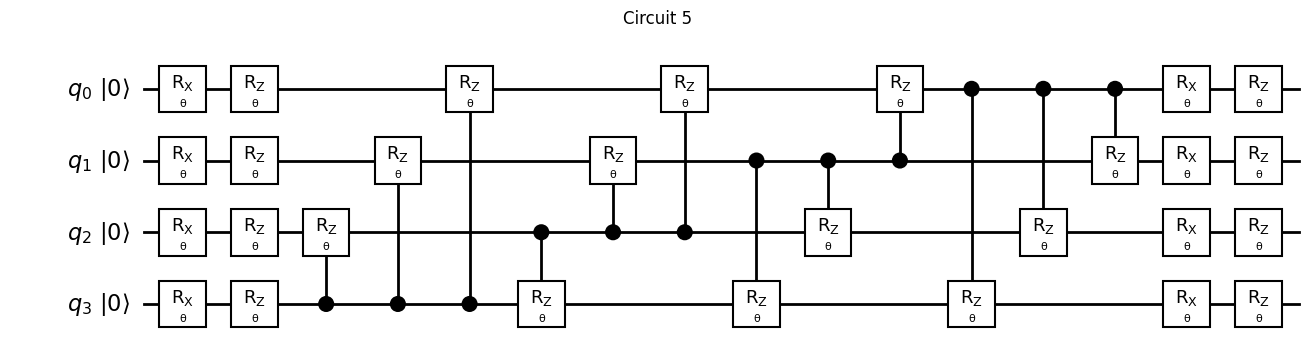

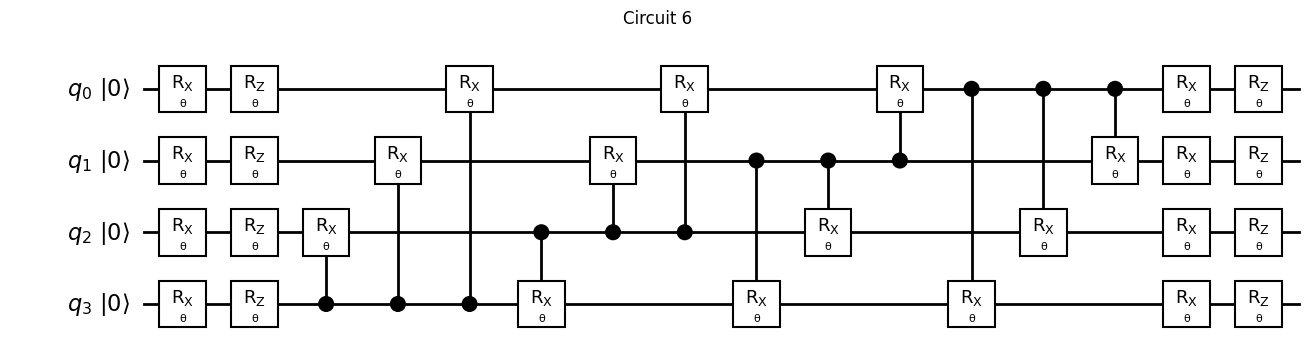

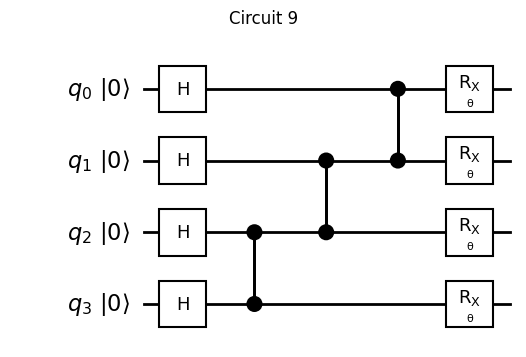

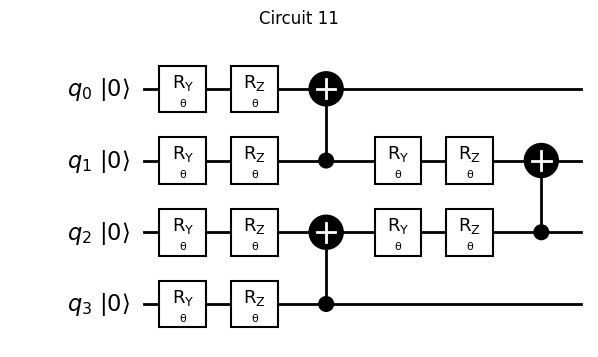

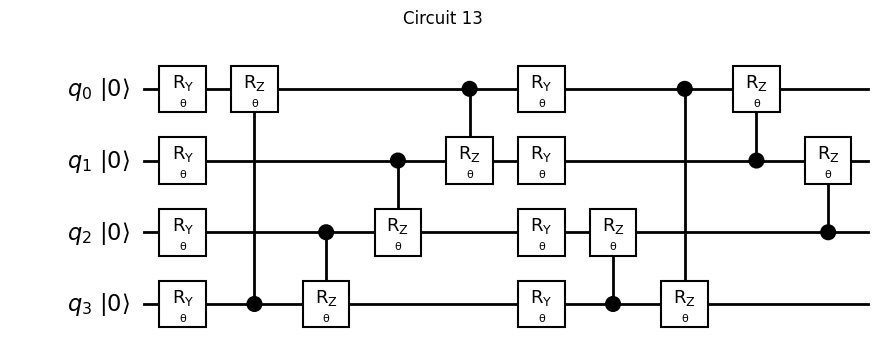

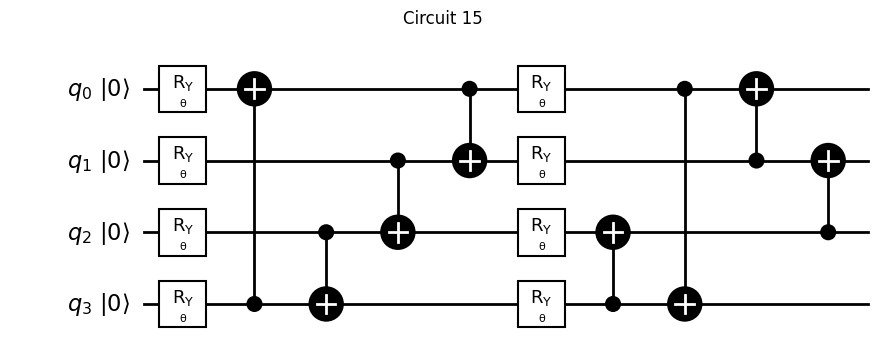

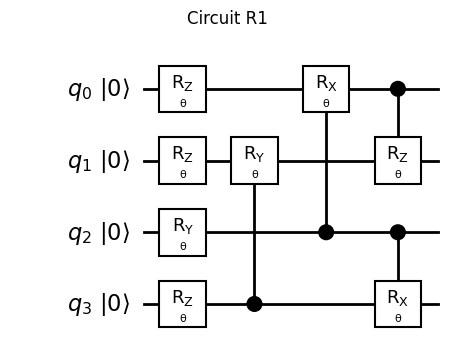

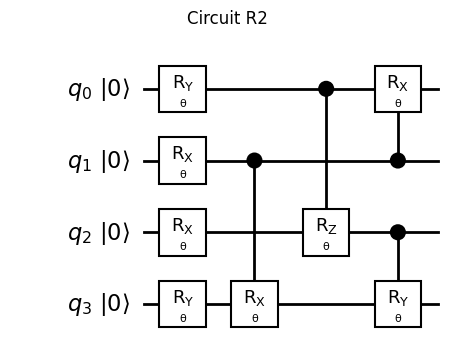

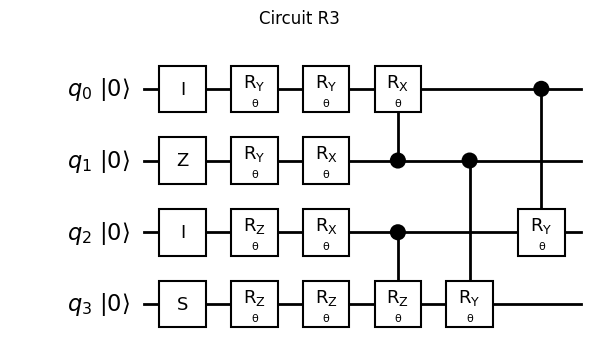

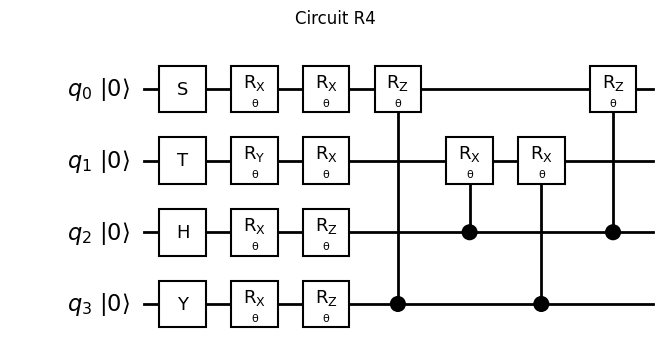

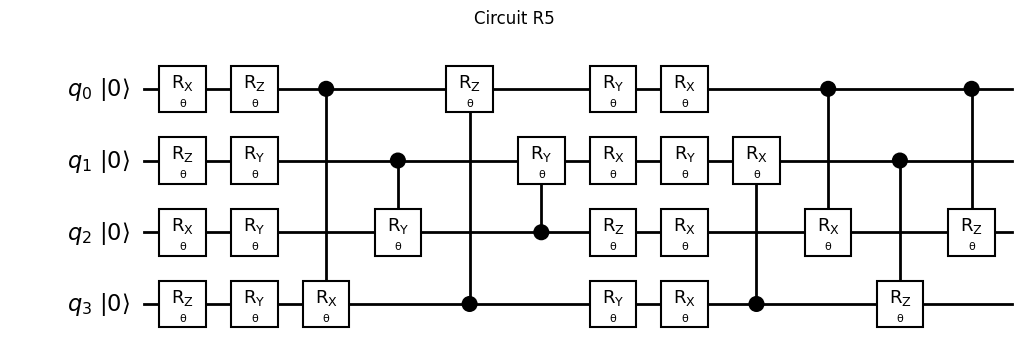

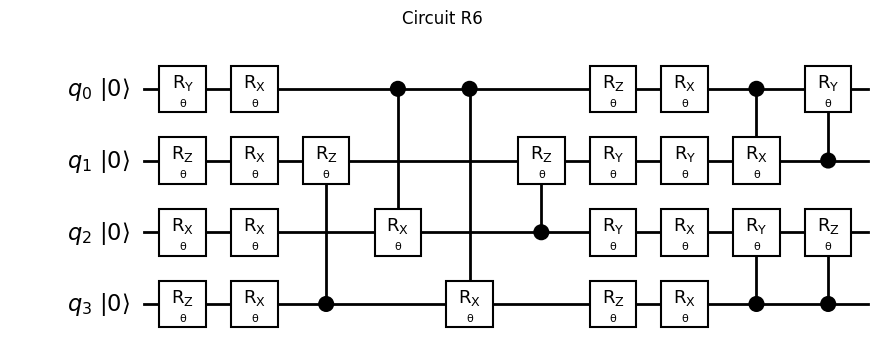

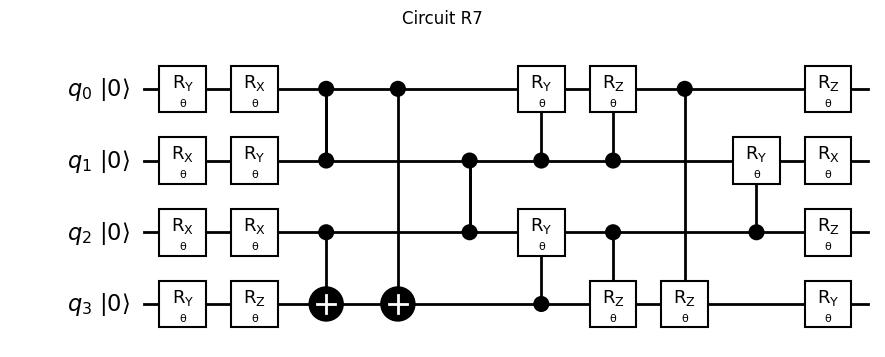

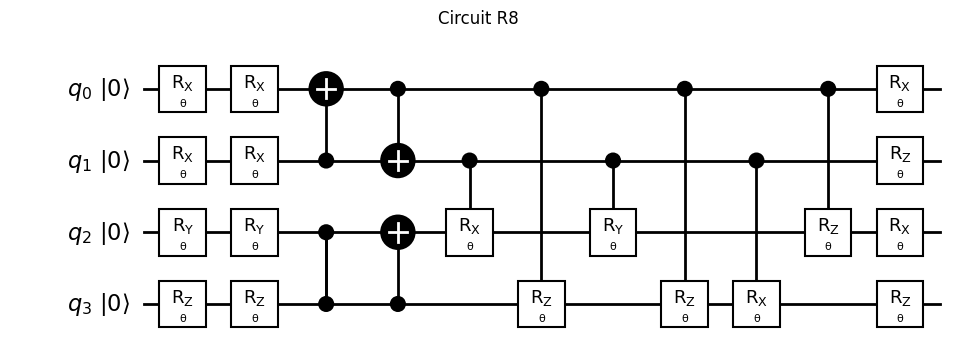

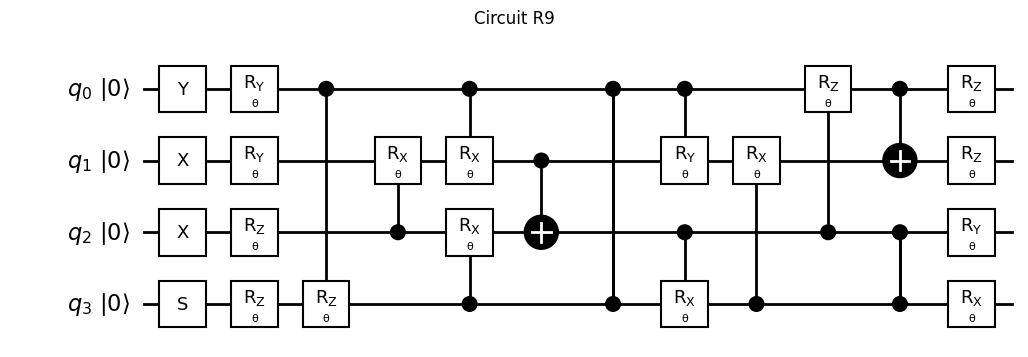

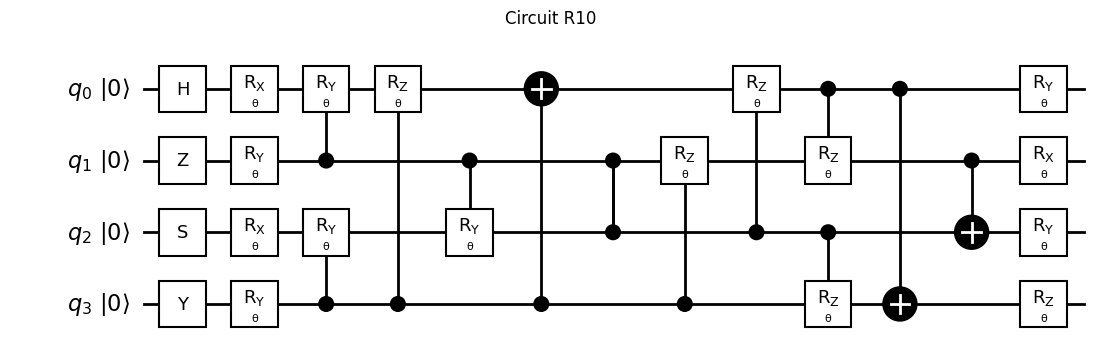

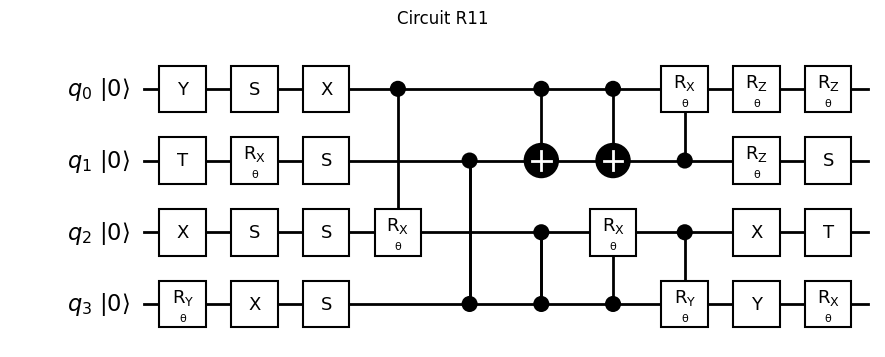

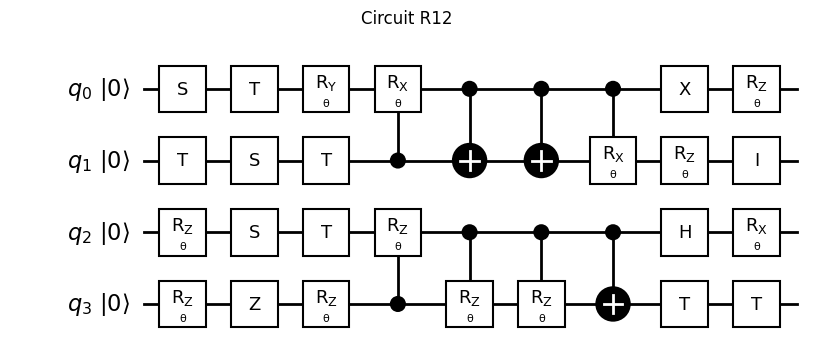

In [74]:
num_of_qubits = 4
samples = 100
dim = 2 ** num_of_qubits  # Hilbert space dimension
num_of_circuits = 8 + 12

# Arrays to store pure vectors and noisy density matrices
states = np.zeros((num_of_circuits, samples, dim, 1), dtype=complex)       # statevectors (ideal)
noisy_states = np.zeros((num_of_circuits, samples, dim, dim), dtype=complex)  # density matrices

# circuits from the paper
circuits_gates_list = [
    [  # Circuit 1
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ]
    ],
    [  # Circuit 2
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ],
        [CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=3)],
        [CircuitGate(GATES.CNOT, target_qubit=1, control_qubit=2)],
        [CircuitGate(GATES.CNOT, target_qubit=0, control_qubit=1)],
        
    ],
    [   # Circuit 5
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ],
        [CircuitGate(GATES.CRz, target_qubit=2, control_qubit=3)],
        [CircuitGate(GATES.CRz, target_qubit=1, control_qubit=3)],
        [CircuitGate(GATES.CRz, target_qubit=0, control_qubit=3)],
        
        [CircuitGate(GATES.CRz, target_qubit=3, control_qubit=2)],
        [CircuitGate(GATES.CRz, target_qubit=1, control_qubit=2)],
        [CircuitGate(GATES.CRz, target_qubit=0, control_qubit=2)],
        
        [CircuitGate(GATES.CRz, target_qubit=3, control_qubit=1)],
        [CircuitGate(GATES.CRz, target_qubit=2, control_qubit=1)],
        [CircuitGate(GATES.CRz, target_qubit=0, control_qubit=1)],
        
        [CircuitGate(GATES.CRz, target_qubit=3, control_qubit=0)],
        [CircuitGate(GATES.CRz, target_qubit=2, control_qubit=0)],
        [CircuitGate(GATES.CRz, target_qubit=1, control_qubit=0)],
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ]
        
    ],
    [   # Circuit 6
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ],
        [CircuitGate(GATES.CRx, target_qubit=2, control_qubit=3)],
        [CircuitGate(GATES.CRx, target_qubit=1, control_qubit=3)],
        [CircuitGate(GATES.CRx, target_qubit=0, control_qubit=3)],
        
        [CircuitGate(GATES.CRx, target_qubit=3, control_qubit=2)],
        [CircuitGate(GATES.CRx, target_qubit=1, control_qubit=2)],
        [CircuitGate(GATES.CRx, target_qubit=0, control_qubit=2)],
        
        [CircuitGate(GATES.CRx, target_qubit=3, control_qubit=1)],
        [CircuitGate(GATES.CRx, target_qubit=2, control_qubit=1)],
        [CircuitGate(GATES.CRx, target_qubit=0, control_qubit=1)],
        
        [CircuitGate(GATES.CRx, target_qubit=3, control_qubit=0)],
        [CircuitGate(GATES.CRx, target_qubit=2, control_qubit=0)],
        [CircuitGate(GATES.CRx, target_qubit=1, control_qubit=0)],
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ]
    ],
    
    [   # Circuit 9
        [
            CircuitGate(GATES.H, target_qubit=0),
            CircuitGate(GATES.H, target_qubit=1),
            CircuitGate(GATES.H, target_qubit=2),
            CircuitGate(GATES.H, target_qubit=3),
        ],
        
        [CircuitGate(GATES.CZ, target_qubit=3, control_qubit=2)],
        [CircuitGate(GATES.CZ, target_qubit=2, control_qubit=1)],
        [CircuitGate(GATES.CZ, target_qubit=1, control_qubit=0)],
        
        [
            CircuitGate(GATES.Rx, target_qubit=0),
            CircuitGate(GATES.Rx, target_qubit=1),
            CircuitGate(GATES.Rx, target_qubit=2),
            CircuitGate(GATES.Rx, target_qubit=3),
        ],
    ],
    [   # Circuit 11
        [
            CircuitGate(GATES.Ry, target_qubit=0),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Ry, target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=3),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=0),
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
            CircuitGate(GATES.Rz, target_qubit=3),
        ],
        [
            CircuitGate(GATES.CNOT, target_qubit=0, control_qubit=1),
            CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=3),
        ],
        [
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Ry, target_qubit=2),
        ],
        [
            CircuitGate(GATES.Rz, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=2),
        ],
        [CircuitGate(GATES.CNOT, target_qubit=1, control_qubit=2)]
    ],
    [   # Circuit 13
        [
            CircuitGate(GATES.Ry, target_qubit=0),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Ry, target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=3),
        ],
        [CircuitGate(GATES.CRz, target_qubit=0, control_qubit=3)],
        [CircuitGate(GATES.CRz, target_qubit=3, control_qubit=2)],
        [CircuitGate(GATES.CRz, target_qubit=2, control_qubit=1)],
        [CircuitGate(GATES.CRz, target_qubit=1, control_qubit=0)],
        [
            CircuitGate(GATES.Ry, target_qubit=0),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Ry, target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=3),
        ],
        [CircuitGate(GATES.CRz, target_qubit=2, control_qubit=3)],
        [CircuitGate(GATES.CRz, target_qubit=3, control_qubit=0)],
        [CircuitGate(GATES.CRz, target_qubit=0, control_qubit=1)],
        [CircuitGate(GATES.CRz, target_qubit=1, control_qubit=2)],
    ],
    [   # Circuit 15
        [
            CircuitGate(GATES.Ry, target_qubit=0),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Ry, target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=3),
        ],
        [CircuitGate(GATES.CNOT, target_qubit=0, control_qubit=3)],
        [CircuitGate(GATES.CNOT, target_qubit=3, control_qubit=2)],
        [CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=1)],
        [CircuitGate(GATES.CNOT, target_qubit=1, control_qubit=0)],
        [
            CircuitGate(GATES.Ry, target_qubit=0),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Ry, target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=3),
        ],
        [CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=3)],
        [CircuitGate(GATES.CNOT, target_qubit=3, control_qubit=0)],
        [CircuitGate(GATES.CNOT, target_qubit=0, control_qubit=1)],
        [CircuitGate(GATES.CNOT, target_qubit=1, control_qubit=2)],
    ]
]

labels=["Circuit 1", "Circuit 2", "Circuit 5", "Circuit 6", "Circuit 9", "Circuit 11", "Circuit 13", "Circuit 15"]

# 12 random circuits
labels.extend([f"Circuit R{i}" for i in range(1, 13)])

# 2 circuits of each type 
layers1 = [
    ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
    ("2q", 2, TWO_QUBITS_PARAMETRISED_GATE_SET),
]

layers2 = [
    ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
    ("1q", 2, ONE_QUBIT_PARAMETRISED_GATE_SET),
    ("2q", 2, TWO_QUBITS_PARAMETRISED_GATE_SET),
]

layers3 = [
    ("1q", 2, ONE_QUBIT_PARAMETRISED_GATE_SET),
    ("2q", 2, TWO_QUBITS_PARAMETRISED_GATE_SET),
    ("1q", 2, ONE_QUBIT_PARAMETRISED_GATE_SET),
    ("2q", 2, TWO_QUBITS_PARAMETRISED_GATE_SET),
] 

layers4 = [
    ("1q", 2, ONE_QUBIT_PARAMETRISED_GATE_SET),
    ("2q", 2, TWO_QUBITS_FIXED_GATE_SET),
    ("2q", 3, TWO_QUBITS_PARAMETRISED_GATE_SET),
    ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
]

layers5 = [
    ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
    ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
    
    ("2q", 2, TWO_QUBITS_PARAMETRISED_GATE_SET),
    ("2q", 1, TWO_QUBITS_FIXED_GATE_SET),
    
    ("2q", 2, TWO_QUBITS_PARAMETRISED_GATE_SET),
    ("2q", 1, TWO_QUBITS_FIXED_GATE_SET),
    
    ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
] 

layers6 = [
    ("1q", 3, ONE_QUBIT_GATES),
    ("2q", 4, TWO_QUBITS_GATES),
    ("1q", 2, ONE_QUBIT_GATES),
] 

for layers_types in [layers1, layers2, layers3, layers4, layers5, layers6]:
    for _ in range(2):
        sampled_gates = sample_random_gates(num_of_qubits=num_of_qubits,
                                            layers=layers_types,
                                            rng=RNG)
        
        circuits_gates_list.append(sampled_gates)    

circuits = []


for gates, title in zip(circuits_gates_list, labels):
    # plot circuit
    fig = get_circuit_plot(gates, num_of_qubits, plot_barriers = False)
    fig.axes[0].set_title(title)

    plt.tight_layout()
    plt.show() 
    
    #definee circuit
    circuits.append(Circuit(
            state=STATES.generate_zero_n_qubit_state(num_of_qubits),
            gates=gates,
            rng=RNG,
            depolarizing_noise=DepolarizingNoise(),
            spam_noise=SPAMNoise(),
            tdc_noise=TDCNoise()
        )
    ) 


In [75]:
dim = 2 ** num_of_qubits  # Hilbert space dimension
# Arrays to store pure vectors and noisy density matrices

layers = 5

# One scalar per (circuit, layer)
expressibilities         = np.zeros((num_of_circuits, layers), dtype=float)  # KL (ideal ‖ Haar)
expressibilities_noisy   = np.zeros((num_of_circuits, layers), dtype=float)  # KL (noisy ‖ Haar)
entangling_abilities     = np.zeros((num_of_circuits, layers), dtype=float)  # ⟨Q⟩ (ideal)
entangling_abilities_noisy = np.zeros((num_of_circuits, layers), dtype=float)  # ⟨Q̃⟩ (noisy)


for circ_idx, circuit in enumerate(circuits):
    print(f"Circuit: {circ_idx}")
    for layer_idx in range(layers):
        states = np.zeros((samples, dim, 1), dtype=complex)       # statevectors (ideal)
        noisy_states = np.zeros((samples, dim, dim), dtype=complex)  # density matrices
    
        for i in range(samples):
            circuit.simulate_circuit_n_rounds(layer_idx+1)
            
            states[i, :, :] = circuit.state.qubit_vector
            noisy_states[i, :, :] = circuit.noisy_dm.rho
            
            circuit.reset_circuit()
            
        # --- Expressibility (KL to Haar) ---
        KL_i, KL_n = kl_expressibility_one_circuit(states, noisy_states, num_bins=100)
        expressibilities[circ_idx, layer_idx] = float(KL_i)
        expressibilities_noisy[circ_idx, layer_idx] = float(KL_n)

        # --- Entangling capability (averages over samples) ---
        Ent_i = entangling_capability_ideal_from_states(states)
        Ent_n = entangling_capability_noisy_from_density(noisy_states)

        entangling_abilities[circ_idx, layer_idx] = float(Ent_i)
        entangling_abilities_noisy[circ_idx, layer_idx] = float(Ent_n)
        
    

Circuit: 0
Circuit: 1
Circuit: 2
Circuit: 3
Circuit: 4
Circuit: 5
Circuit: 6
Circuit: 7
Circuit: 8
Circuit: 9
Circuit: 10
Circuit: 11
Circuit: 12
Circuit: 13
Circuit: 14
Circuit: 15
Circuit: 16
Circuit: 17
Circuit: 18
Circuit: 19


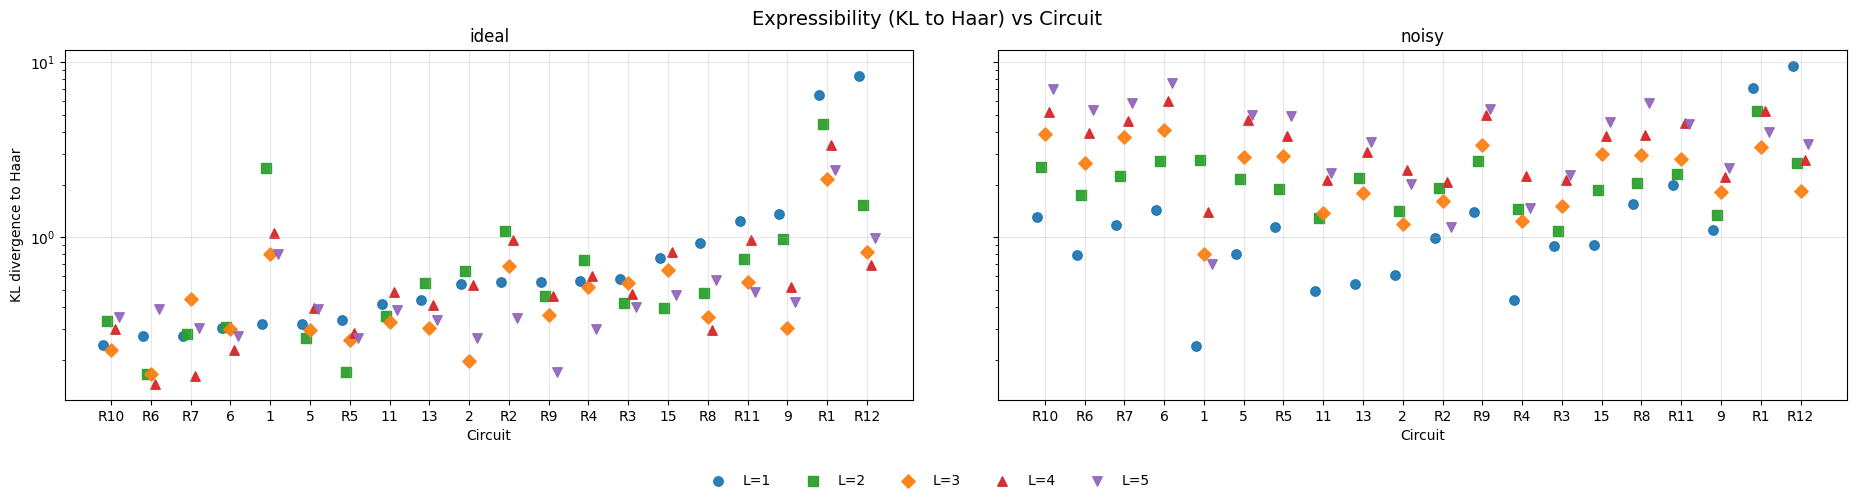

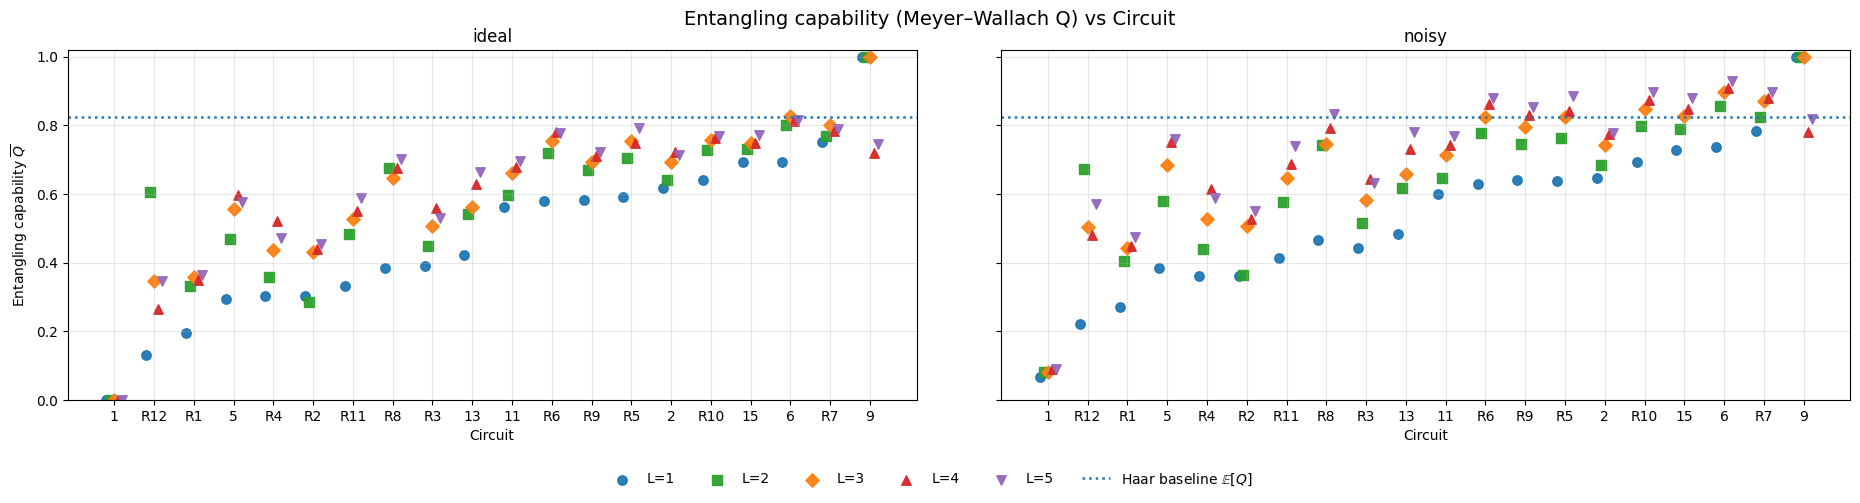

In [76]:
plot_expressibility_layers_by_circuit(expressibilities, expressibilities_noisy, labels)

plot_entangling_capability_layers_by_circuit(
    entangling_abilities, entangling_abilities_noisy, labels, num_qubits=num_of_qubits
)

* **Expressibility (KL→Haar).**

    * *Ideal:* KL generally drops with depth → deeper circuits explore Hilbert space better.
    * *Noisy:* KL tends to rise with depth

* **Entangling capability (Meyer–Wallach $\overline{Q}$).**
    * *Ideal:* $\overline{Q}$ grows with layers and approaches the Haar baseline ($\approx 0.82$ for $n=4$).
    * *Noisy:* $\overline{Q}$ is shifted upward for all depths and often exceeds the Haar line, the linear-entropy proxy counts mixedness as well as entanglement, and noise increases mixedness. The gap typically widens with depth.

Noise materially affects both metrics, and its impact amplifies with layer count: it **hurts expressibility** (esp. at larger $L$) while **inflating the $\overline{Q}$ proxy** due to added mixedness.


### Expressibility saturation

Let \$\mathrm{Expr}(L)\$ be the expressibility of a PQC with \$L\$ layers (e.g., a KL divergence to the Haar baseline; lower is better). As depth increases, improvements typically diminish until \$\mathrm{Expr}(L)\$ plateaus. This **expressibility saturation** means further layers give negligible reduction:


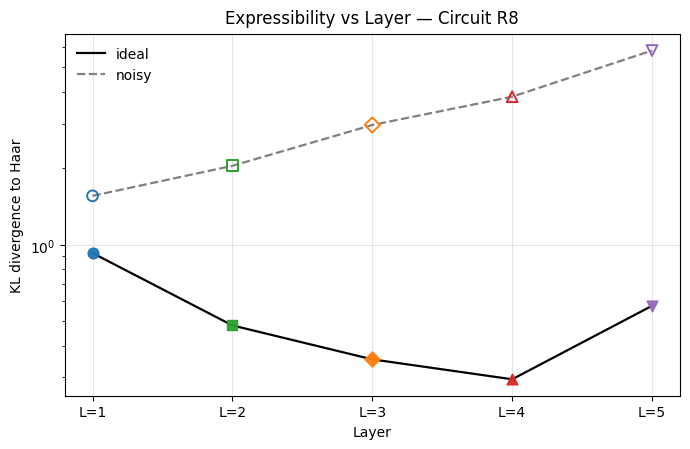

In [78]:
idx = 15
plot_expressibility_vs_layers_for_circuit(
    expressibilities[idx],
    expressibilities_noisy[idx],
    circuit_label=labels[idx],
    log_scale=True
)